In [47]:
import gdown

gurl = 'https://drive.google.com/uc?id=1-aSV5o-XpbN5_PswIZ3KgGTQPiZCx8eM'
gdown.download(gurl, 'bert.csv.xz')

Downloading...
From: https://drive.google.com/uc?id=1-aSV5o-XpbN5_PswIZ3KgGTQPiZCx8eM
To: /home/painstudy/dl_asa/bert.csv.xz
100%|██████████| 37.0M/37.0M [00:27<00:00, 1.32MB/s]


'bert.csv.xz'

In [142]:
!pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     |████████████████████████████████| 1837.6 MB 4.4 kB/s  eta 0:00:01   |▌                               | 25.6 MB 10.3 MB/s eta 0:02:57     |▋                               | 33.3 MB 10.3 MB/s eta 0:02:57     |█▉                              | 104.4 MB 11.1 MB/s eta 0:02:36     |██████▉                         | 395.2 MB 11.6 MB/s eta 0:02:05     |█████████████████████████▉      | 1481.3 MB 9.4 MB/s eta 0:00:38     |████████████████████████████▌   | 1633.7 MB 10.0 MB/s eta 0:00:21     |█████████████████████████████▎  | 1679.2 MB 10.8 MB/s eta 0:00:15     |██████████████████████████████▏ | 1730.9 MB 10.2 MB/s eta 0:00:11
     |████████████████████████████████| 23.4 MB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 645 kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# Preprocessing

## Data processing

In [ ]:
import sys

# 모듈 yaml이 설치된 path를 지정
sys.path.append('/usr/lib/python3/dist-packages')

In [51]:
import pandas as pd
import numpy as np
import os, datetime, random
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 모듈 yaml이 설치된 path를 지정
sys.path.append('/usr/lib/python3/dist-packages')


# data 다운받기
df_data = pd.read_csv('bert.csv')
n_c = len(np.unique(df_data['opid'].tolist()))
print(f'전처리 전 caseid: {n_c}')

# 전처리1 : 결측치 제거
idx_drop = df_data[df_data['premedi_summary']=='.'].index
print(f'premdi summary 값이 없는 opid 수 : {len(idx_drop)}')
df_data.drop(idx_drop, inplace=True)
print(f'결측치 제거 후 전체 opid 수: {len(df_data)}')

# 전처리2 : opid가 중복되거나, nan값이 있는 경우 제외 (현 연구에서는 없음)
df_data.dropna(how='any', inplace=True)
df_data.drop_duplicates(subset=['opid'], inplace=True)
print(f'opid가 중복되거나 nan 값 제외 후 opid 수 : {len(df_data)}')

# 전처리3 : 2010년 이전 데이터 제외 (opid: yymmddxxx 형태)
df_data = df_data.loc[df_data['opid'] > 100000000]
print(f'2010년 이전 데이터 제외 후 opid 수 : {len(df_data)}')

df_data.reset_index(drop=True, inplace=True)    
df_data

전처리 전 caseid: 593127
premdi summary 값이 없는 opid 수 : 757
결측치 제거 후 전체 opid 수: 592370
opid가 중복되거나 nan 값 제외 후 opid 수 : 592370
2010년 이전 데이터 제외 후 opid 수 : 484659


,opid,premedi_asa,premedi_summary
0,100101001,1,# no remarkable findings in preOP labs
1,100101002,1,EVD insertion state s/p Em. Endoscopic Bx & I...
2,100102001,3,#NSCLC (SqCc) pT2N1(peribronchial) with brain ...
3,100102004,1,"#1. DM type 2 #2. sepsis d/t burn wound,UT..."
4,100102005,1,osteogenesis imperfecta
...,...,...,...
484654,221231003,3,"* INR/PLT/Hb 1.24/49K/7.7 (LDRT RBC 재고 충분, LD ..."
484655,221231005,1,"# Recurrent POP, s/p APR, cystocele repair op ..."
484656,221231006,1,SB mass r/o lymphoma r/o obsturction
484657,221231007,3,"작성중 * DDLT recipient 김양덕 38608771, A+, F/66, 1..."


### input 길이 validation

In [93]:
# 573602 -> 3903
row['premedi_summary']

"* 안형국 71227605, M/31Y, 170.2cm/88.75kg(BMI 30.64), Pf. 곽재건, Op plan: pacemaker genenator change: DDD* V/S: BP 118/67-124/71, HR 68-70, RR 20-24, BT 36.3-36.7, SpO2(RA) 81-89% /@V'(RA) 7.378-43.7-51.1-24.3-85.0% /@Hb/Plt/INR 15.6/45K/1.35* Pacemaker (DDD, 70 bpm)* Cyanosis/Clubbing(+/+)* 가슴 전반에 걸쳐 찌릿한 느낌 1~4회/1달* h/o recurrent epistaxis(+) ★ bleeding tendency★# Pacemaker battery exhaustion# DORV, DIRV, Functional single ventricle(RV type), combined PS, sildenafil, ACEi, furosemide, spironolactone, CPG(7.6-hold)- s/p interatrial septectomy('91, o/s), s/p modified Fontan op('93.4, o/s)- s/p PM insertion d/t sinus node dysfx('98.9), s/p several generator change(last: '16.3, VVI->DDD mode)- h/o postop medistinitis, s/p VATS exploratory thoracotomy('16.3, G/A s event, CGr I, Lt DLT 37Fr, FFP 2u, PC 6u tf)- @ECG('22.05.02): Atrial-paced rhythm. Rightward axis. Cannot rule out Inferior infarct , age undetermined. T wave abnormality, consider lateral ischemia.- @Echo('20.09): {S,D,D} left arch

In [104]:
len_sum = []
for idx, row in tqdm(df_data.iterrows(), total=df_data.shape[0]):
    len_sum.append(len(row['premedi_summary']))

100%|██████████| 592370/592370 [00:31<00:00, 19047.36it/s]


(3903, 1, 247.10821614869084)

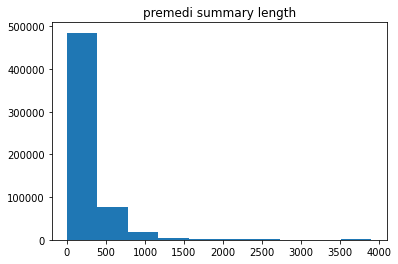

In [70]:
import matplotlib.pyplot as plt

plt.hist(len_sum)
plt.title('premedi summary length')
np.max(len_sum), np.min(len_sum), np.mean(len_sum)

### input 길이의 max 설정

In [52]:
MAX_SEQ_LEN = 512

# premedi_summary의 length 열 생성
df_data['seq_len'] = df_data['premedi_summary'].apply(lambda x: len(x))
df_final = df_data[df_data['seq_len']<MAX_SEQ_LEN]

# premedi_asa 값 1~6 => 0~5로 맞추기
df_final['premedi_asa'] = df_final['premedi_asa']-1
df_final.reset_index(drop=True, inplace=True)
df_final

/tmp/ipykernel_3773088/2054323192.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['premedi_asa'] = df_final['premedi_asa']-1


,opid,premedi_asa,premedi_summary,seq_len
0,100101001,0,# no remarkable findings in preOP labs,38
1,100101002,0,EVD insertion state s/p Em. Endoscopic Bx & I...,82
2,100102004,0,"#1. DM type 2 #2. sepsis d/t burn wound,UT...",235
3,100102005,0,osteogenesis imperfecta,23
4,100102006,0,CA/P : 9.0/0.9,14
...,...,...,...,...
421293,221230175,1,* Rt. arm save# Rt. breast ca /@USG: Rt. 1H 4....,88
421294,221230176,1,* Rt. arm save# Rt. breast ca /@USG: multifoca...,126
421295,221231005,0,"# Recurrent POP, s/p APR, cystocele repair op ...",216
421296,221231006,0,SB mass r/o lymphoma r/o obsturction,36


## Embedding input

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [53]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)
       
        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
        
        # token_type_id는 세그먼트 임베딩을 위한 것으로 이번 예제는 문장이 1개이므로 전부 0으로 통일.
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

X, Y = convert_examples_to_features(df_final['premedi_summary'], df_final['premedi_asa'], max_seq_len=MAX_SEQ_LEN, tokenizer=tokenizer)

  0%|          | 0/421298 [00:00<?, ?it/s]/home/painstudy/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 421298/421298 [05:45<00:00, 1218.69it/s]


## Train, test set 나누기

In [54]:
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything()


# train, test set
c = df_final['opid']
caseids = list(np.unique(c))
random.shuffle(caseids)

ntest = max(1, int(len(caseids) * 0.25))
ntrain = len(caseids) - ntest

caseid_train = caseids[:ntrain]
caseid_test = caseids[ntrain:]

print('전체 caseid 수: {}'.format(len(caseids)))
print('train caseid 수: {}, test caseid 수: {}'.format(len(caseid_train), len(caseid_test)))

pickle.dump(caseid_train, open(f'cache/dataset/caseid_train_max{MAX_SEQ_LEN}','wb'))
pickle.dump(caseid_test, open(f'cache/dataset/caseid_test_max{MAX_SEQ_LEN}','wb'))

train_mask = np.isin(c, caseid_train)
test_mask = np.isin(c, caseid_test)


list_train, list_test = [], []
for i in range(len(X)):
    list_train.append(np.array(X[i])[train_mask])
    list_test.append(np.array(X[i])[test_mask])    
x_train = (list_train[0], list_train[1], list_train[2])
x_test = (list_test[0], list_test[1], list_test[2])

Y = np.array(Y)
c = np.array(c)
y_train = Y[train_mask]
y_test = Y[test_mask]
c_train = c[train_mask]
c_test = c[test_mask]


print('x train shape:', np.array(x_train).shape)
print('y train shape:', y_train.shape)
print(f'y mean: {np.mean(Y)}')

전체 caseid 수: 421298
train caseid 수: 315974, test caseid 수: 105324
y shape: (421298,)
y mean: 0.618863607232885


In [100]:
# train, val도 1-fold로 split
n_train = int(len(x_train[0])*0.8)
n_val = int(len(x_train[0])*0.2)

X_train = (x_train[0][:n_train], x_train[1][:n_train], x_train[2][:n_train])
X_val = (x_train[0][n_train:], x_train[1][n_train:], x_train[2][n_train:])

Y_train = y_train[:n_train]
Y_val = y_train[n_train:]
Y_test = y_test

print(np.array(X_train).shape, Y_train.shape)

(3, 252779, 512) (252779,)


In [106]:
# Y값 분포
len(np.where(Y==5)[0]), len(np.where(Y==4)[0]), len(np.where(Y==3)[0]), len(np.where(Y==2)[0]), len(np.where(Y==1)[0]), len(np.where(Y==2)[0])

(123, 117, 935, 19488, 217862, 19488)

In [159]:
# 최대 길이: 512 - input 예시
input_id = x_train[0][0]
attention_mask = x_train[1][0]
token_type_id = x_train[2][0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [   101    158  46876  45893    122  16323  18392   9665  17655  10172
  49183    117    186 107485  47707  45546    113    116    114    117
  60369  10161  10173  63952  11046    113    116    114    102      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0     

# BERT model training

In [55]:
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

* 예시 : function API

In [135]:
model = TFBertModel.from_pretrained("bert-base-multilingual-cased")

input_ids_layer = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32)
attention_masks_layer = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32)

outputs = model([input_ids_layer, attention_masks_layer, token_type_ids_layer])

2023-02-06 17:55:53.360380: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 17:55:54.583514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30973 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0
Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if 

In [ ]:
# TPU 작동을 위한 코드 TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [57]:
class TFBertForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(TFBertForSequenceClassification, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.classifier = tf.keras.layers.Dense(num_labels,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='softmax',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)

        return prediction

In [101]:
#with strategy.scope():
model = TFBertForSequenceClassification("bert-base-multilingual-cased", num_labels=6)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
model.save_weights(f'result/BERT/initial_weights.hdf5')

In [102]:
# tf.data 이용
BATCH_SIZE = 32
BUFFER_SIZE = 100000

train_dataset = tf.data.Dataset.from_tensor_slices((
    X_train, Y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    X_val, Y_val
))

In [75]:
lens = 1000
x_train2 = (x_train[0][:lens], x_train[1][:lens], x_train[2][:lens])
y_train2 = y_train[:lens]

In [103]:
model.fit(
    train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE), epochs=10, validation_data=val_dataset.batch(BATCH_SIZE), callbacks=[EarlyStopping(
    monitor="val_loss",
    patience=2)])


Epoch 1/10


2023-02-07 01:59:52.259857: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 192.00MiB (rounded to 201326592)requested by op tf_bert_for_sequence_classification/tf_bert_model/bert/encoder/layer_._9/intermediate/Gelu/truediv
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-07 01:59:52.259970: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-02-07 01:59:52.260003: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 138, Chunks in use: 136. 34.5KiB allocated for chunks. 34.0KiB in use in bin. 1.1KiB client-requested in use in bin.
2023-02-07 01:59:52.260022: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in 

ResourceExhaustedError:  failed to allocate memory
	 [[node tf_bert_for_sequence_classification/tf_bert_model/bert/encoder/layer_._9/intermediate/Gelu/truediv
 (defined at /home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/tf_stack.py:193)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_138654]

Errors may have originated from an input operation.
Input Source operations connected to node tf_bert_for_sequence_classification/tf_bert_model/bert/encoder/layer_._9/intermediate/Gelu/truediv:
In[0] tf_bert_for_sequence_classification/tf_bert_model/bert/encoder/layer_._9/intermediate/dense/BiasAdd:	
In[1] tf_bert_for_sequence_classification/tf_bert_model/bert/encoder/layer_._9/intermediate/Gelu/Cast/x:

Operation defined at: (most recent call last)
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_3773088/740028592.py", line 1, in <module>
>>>     model.fit(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 910, in __call__
>>>     result = self._call(*args, **kwds)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 975, in _call
>>>     return self._stateless_fn(*args, **kwds)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3129, in __call__
>>>     filtered_flat_args) = self._maybe_define_function(args, kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3557, in _maybe_define_function
>>>     graph_function = self._create_graph_function(args, kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3392, in _create_graph_function
>>>     func_graph_module.func_graph_from_py_func(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1143, in func_graph_from_py_func
>>>     func_outputs = python_func(*func_args, **func_kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 672, in wrapped_fn
>>>     out = weak_wrapped_fn().__wrapped__(*args, **kwds)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1118, in autograph_handler
>>>     return autograph.converted_call(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py", line 1316, in run
>>>     return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2892, in call_for_each_replica
>>>     return self._call_for_each_replica(fn, args, kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3695, in _call_for_each_replica
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/tmp/ipykernel_3773088/1778174173.py", line 12, in call
>>>     outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/modeling_tf_utils.py", line 1088, in run_call_with_unpacked_inputs
>>>     - **config_class** ([`PretrainedConfig`]) -- A subclass of [`PretrainedConfig`] to use as configuration class
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1115, in call
>>>     outputs = self.bert(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/modeling_tf_utils.py", line 1088, in run_call_with_unpacked_inputs
>>>     - **config_class** ([`PretrainedConfig`]) -- A subclass of [`PretrainedConfig`] to use as configuration class
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 871, in call
>>>     encoder_outputs = self.encoder(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 556, in call
>>>     for i, layer_module in enumerate(self.layer):
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 444, in for_stmt
>>>     _py_for_stmt(iter_, extra_test, body, None, None)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 493, in _py_for_stmt
>>>     body(target)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 459, in protected_body
>>>     original_body(protected_iter)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 562, in call
>>>     layer_outputs = layer_module(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 518, in call
>>>     intermediate_output = self.intermediate(hidden_states=attention_output)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 422, in call
>>>     hidden_states = self.intermediate_act_fn(hidden_states)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py", line 1096, in op_dispatch_handler
>>>     return dispatch_target(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/activations.py", line 351, in gelu
>>>     return tf.nn.gelu(x, approximate)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py", line 1096, in op_dispatch_handler
>>>     return dispatch_target(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py", line 3714, in gelu
>>>     features / math_ops.cast(1.4142135623730951, features.dtype)))
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1383, in binary_op_wrapper
>>>     return func(x, y, name=name)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py", line 1096, in op_dispatch_handler
>>>     return dispatch_target(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1566, in truediv
>>>     return _truediv_python3(x, y, name)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1504, in _truediv_python3
>>>     return gen_math_ops.real_div(x, y, name=name)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py", line 7901, in real_div
>>>     _, _, _op, _outputs = _op_def_library._apply_op_helper(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 744, in _apply_op_helper
>>>     op = g._create_op_internal(op_type_name, inputs, dtypes=None,
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 689, in _create_op_internal
>>>     return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3697, in _create_op_internal
>>>     ret = Operation(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2101, in __init__
>>>     self._traceback = tf_stack.extract_stack_for_node(self._c_op)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/tf_stack.py", line 193, in extract_stack_for_node
>>>     return _tf_stack.extract_stack_for_node(
>>> 

In [76]:
model.fit(x_train2, y_train2, epochs=10, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)])

Epoch 1/10


2023-02-06 22:48:20.100240: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 384.00MiB (rounded to 402653184)requested by op tf_bert_for_sequence_classification_3/tf_bert_model_3/bert/encoder/layer_._11/attention/self/MatMul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-06 22:48:20.100364: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-02-06 22:48:20.100397: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 127, Chunks in use: 125. 31.8KiB allocated for chunks. 31.2KiB in use in bin. 972B client-requested in use in bin.
2023-02-06 22:48:20.100416: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in u

ResourceExhaustedError:  OOM when allocating tensor with shape[32,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node tf_bert_for_sequence_classification_3/tf_bert_model_3/bert/encoder/layer_._11/attention/self/MatMul
 (defined at /home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/tf_stack.py:193)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_72323]

Errors may have originated from an input operation.
Input Source operations connected to node tf_bert_for_sequence_classification_3/tf_bert_model_3/bert/encoder/layer_._11/attention/self/MatMul:
In[0] tf_bert_for_sequence_classification_3/tf_bert_model_3/bert/encoder/layer_._11/attention/self/transpose_2:	
In[1] tf_bert_for_sequence_classification_3/tf_bert_model_3/bert/encoder/layer_._11/attention/self/transpose:

Operation defined at: (most recent call last)
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_3773088/1762814919.py", line 1, in <module>
>>>     model.fit(x_train2, y_train2, epochs=10, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 910, in __call__
>>>     result = self._call(*args, **kwds)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 942, in _call
>>>     return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3129, in __call__
>>>     filtered_flat_args) = self._maybe_define_function(args, kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3553, in _maybe_define_function
>>>     return self._define_function_with_shape_relaxation(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3475, in _define_function_with_shape_relaxation
>>>     graph_function = self._create_graph_function(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3392, in _create_graph_function
>>>     func_graph_module.func_graph_from_py_func(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1143, in func_graph_from_py_func
>>>     func_outputs = python_func(*func_args, **func_kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 672, in wrapped_fn
>>>     out = weak_wrapped_fn().__wrapped__(*args, **kwds)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1118, in autograph_handler
>>>     return autograph.converted_call(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py", line 1316, in run
>>>     return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2892, in call_for_each_replica
>>>     return self._call_for_each_replica(fn, args, kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3695, in _call_for_each_replica
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/tmp/ipykernel_3773088/1778174173.py", line 12, in call
>>>     outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/modeling_tf_utils.py", line 1088, in run_call_with_unpacked_inputs
>>>     - **config_class** ([`PretrainedConfig`]) -- A subclass of [`PretrainedConfig`] to use as configuration class
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1115, in call
>>>     outputs = self.bert(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/modeling_tf_utils.py", line 1088, in run_call_with_unpacked_inputs
>>>     - **config_class** ([`PretrainedConfig`]) -- A subclass of [`PretrainedConfig`] to use as configuration class
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 871, in call
>>>     encoder_outputs = self.encoder(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 556, in call
>>>     for i, layer_module in enumerate(self.layer):
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 444, in for_stmt
>>>     _py_for_stmt(iter_, extra_test, body, None, None)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 493, in _py_for_stmt
>>>     body(target)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 459, in protected_body
>>>     original_body(protected_iter)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 562, in call
>>>     layer_outputs = layer_module(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 472, in call
>>>     self_attention_outputs = self.attention(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 388, in call
>>>     self_outputs = self.self_attention(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/.local/lib/python3.8/site-packages/transformers/models/bert/modeling_tf_bert.py", line 318, in call
>>>     attention_scores = tf.matmul(query_layer, key_layer, transpose_b=True)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py", line 1096, in op_dispatch_handler
>>>     return dispatch_target(*args, **kwargs)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 3653, in matmul
>>>     return gen_math_ops.batch_mat_mul_v2(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1590, in batch_mat_mul_v2
>>>     _, _, _op, _outputs = _op_def_library._apply_op_helper(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 744, in _apply_op_helper
>>>     op = g._create_op_internal(op_type_name, inputs, dtypes=None,
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 689, in _create_op_internal
>>>     return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3697, in _create_op_internal
>>>     ret = Operation(
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2101, in __init__
>>>     self._traceback = tf_stack.extract_stack_for_node(self._c_op)
>>> 
>>>   File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/tensorflow/python/util/tf_stack.py", line 193, in extract_stack_for_node
>>>     return _tf_stack.extract_stack_for_node(
>>> 

core/common_runtime/bfc_allocator.cc:1066] InUse at 7fc96472f000 of size 201326592 next 730
2023-02-06 22:48:20.112277: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fc97072f000 of size 50331648 next 721
2023-02-06 22:48:20.112288: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fc97372f000 of size 50331648 next 732
2023-02-06 22:48:20.112299: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fc97672f000 of size 50331648 next 729
2023-02-06 22:48:20.112311: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fc97972f000 of size 50331648 next 728
2023-02-06 22:48:20.112322: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fc97c72f000 of size 50331648 next 727
2023-02-06 22:48:20.112334: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fc97f72f000 of size 50331648 next 712
2023-02-06 22:48:20.112345: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fc98272f000 of size 50